# Financial ML

In [2]:
!pip install mplfinance
import numpy as np
import pandas as pd
import sklearn
import datetime
import mplfinance as mpf
import matplotlib.pyplot as plt

In [3]:
try:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    link = 'https://drive.google.com/open?id=1Xl9krWLvAUF0IMxFA0hqF2HwG5AejwTN'
    fluff, id = link.split('=')
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('hourAll.csv')  
    data = pd.read_csv('hourAll.csv')
except:
    print('cant colab')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
try:
    from google.colab import files
    uploaded = files.upload()
except:
    print('cant colab')

## Data

In [0]:
class TAQ():
    """TAQ object generated from WRDS database TAQ trade csv file.
    Stores initial CSV as pd dataframe and renames columns"""

    def __init__(self, path='null', data=None):
        if path != 'null':
            self.taqPath = path
            self.rawData = pd.read_csv(path)
        elif data is not None:
            self.rawData = data

        self.data = self.preprocess()
        self.timeBars = self.makeTimeBars()

    def make_timestamp(self, level = 'Min'):
        combined = self.rawData['DATE'].apply(str) + ' ' + self.rawData['TIME_M']
        timestamp = pd.to_datetime(combined)
        return timestamp.dt.floor(level)

    def preprocess(self, level = 'Min'):
        data = self.rawData[['SYM_ROOT', 'EX', 'SIZE', 'PRICE']]
        data = data.rename(columns={"SYM_ROOT": "ticker", "EX": 'exchange', "SIZE" : 'volume', "PRICE": 'price'})
        data['priceXvolume'] = data['price'] * data['volume']
        data['timestamp'] = self.make_timestamp(level)
        data['date'] = data['timestamp'].dt.date
        ticks = data['price'].diff()/abs(data['price'].diff())
        newSym = data['ticker'].ne(data['ticker'].shift(1))
        ticks[newSym] = 0
        ticks = ticks.fillna(method = 'ffill')
        data['ticks'] = ticks
        return data



    def makeTimeBars(self):
        """Will create TimeBars using level specified in pre-processing"""

        groupData = self.data.groupby(['ticker', 'timestamp'])
        volsum = groupData['volume'].sum()
        psum = groupData['priceXvolume'].sum()
        vwap = psum / volsum
        o = groupData['price'].first()
        c = groupData['price'].last()
        high = groupData['price'].max()
        low = groupData['price'].min()
        frame = {'Volume': volsum, 'VWAP': vwap, 'Open': o, 'Close': c, 'High': high, 'Low': low}
        frame = pd.DataFrame(frame)
        return frame

In [5]:
try:
  try:
    taq = TAQ('hourAll.csv')
  except:
    import io
    taq = TAQ(io.BytesIO(uploaded['QQQ1Day.csv']))
except:
    taq = TAQ('QQQ1Day.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
rawData = taq.rawData
rawData.head(100)

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
0,20200102,9:29:57.929553117,P,A,NaN,T,100,85.8000,0,304701,52983525035336,C,NaN
1,20200102,9:29:57.930146264,T,A,NaN,T,100,85.8000,0,304801,3472338191833380689,C,NaN
2,20200102,9:30:00.436516480,N,A,NaN,O,24994,85.9000,0,334001,52983525028169,C,NaN
3,20200102,9:30:00.436537082,N,A,NaN,Q,24994,85.9000,0,334101,52983525028170,C,NaN
4,20200102,9:30:00.438161828,N,A,NaN,NaN,100,85.9000,0,334801,52983525028175,C,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20200102,9:30:34.350369795,D,A,NaN,NaN,100,85.8000,0,560301,71675224217399,C,T
96,20200102,9:30:34.350929223,D,A,NaN,NaN,100,85.8275,0,560401,71675224217400,C,T
97,20200102,9:30:34.366052905,D,A,NaN,NaN,100,85.8600,0,560501,71675224217415,C,T
98,20200102,9:30:34.402349585,D,A,NaN,NaN,100,85.8000,0,560601,71675224217421,C,T


Exchange CODE Description

A NYSE MKT LLC

B NASDAQ OMX BX, Inc.

C National Stock Exchange Inc. (NSX)

D Financial Industry Regulatory Authority, Inc.(FINRA ADF)

I International Securities Exchange, LLC (ISE)

J Bats EDGA Exchange, INC

K Bats EDGX Exchange, Inc.

M Chicago Stock Exchange, Inc. (CHX)

N New York Stock Exchange LLC

P NYSE Arca, Inc.

S Consolidated Tape System

T NASDAQ Stock Exchange, LLC (in Tape A, B securities)

Q NASDAQ Stock Exchange, LLC (in Tape C securities)

V The Investors’ Exchange, LLC (IEX)

W Chicago Broad Options Exchange, Inc.(CBOE)

X NASDAQ OMX PSX, Inc. LLC

Y Bats BYX Exchange, Inc.

Z Bats BZX Exchange, Inc.

In [7]:
taq.data.head(30)

,ticker,exchange,volume,price,priceXvolume,timestamp,date,ticks
0,A,P,100,85.80,8580.00,2020-01-02 09:29:00,2020-01-02,0.0
1,A,T,100,85.80,8580.00,2020-01-02 09:29:00,2020-01-02,0.0
2,A,N,24994,85.90,2146984.60,2020-01-02 09:30:00,2020-01-02,1.0
3,A,N,24994,85.90,2146984.60,2020-01-02 09:30:00,2020-01-02,1.0
4,A,N,100,85.90,8590.00,2020-01-02 09:30:00,2020-01-02,1.0
5,A,N,2,85.55,171.10,2020-01-02 09:30:00,2020-01-02,-1.0
6,A,N,157,85.52,13426.64,2020-01-02 09:30:00,2020-01-02,-1.0
7,A,A,100,85.56,8556.00,2020-01-02 09:30:00,2020-01-02,1.0
8,A,N,41,85.51,3505.91,2020-01-02 09:30:00,2020-01-02,-1.0
9,A,A,100,85.20,8520.00,2020-01-02 09:30:00,2020-01-02,-1.0


In [8]:
taq.timeBars

Volume       VWAP  ...     High      Low
ticker timestamp                               ...                  
A      2020-01-02 09:29:00     200  85.800000  ...  85.8000  85.8000
       2020-01-02 09:30:00   83057  85.884028  ...  85.9500  85.2000
       2020-01-02 09:31:00   38976  85.965001  ...  86.0400  85.7800
       2020-01-02 09:32:00    7126  86.056736  ...  86.2000  85.9700
       2020-01-02 09:33:00    9293  86.140407  ...  86.2500  85.9000
...                            ...        ...  ...      ...      ...
ZYXI   2020-01-02 10:25:00     105   7.950476  ...   7.9600   7.9500
       2020-01-02 10:26:00     300   7.947133  ...   7.9600   7.9390
       2020-01-02 10:27:00     100   7.926500  ...   7.9265   7.9265
       2020-01-02 10:28:00     300   7.917633  ...   7.9229   7.9100
       2020-01-02 10:29:00     100   7.940000  ...   7.9400   7.9400

[267711 rows x 6 columns]

<Figure size 3240x1080 with 0 Axes>

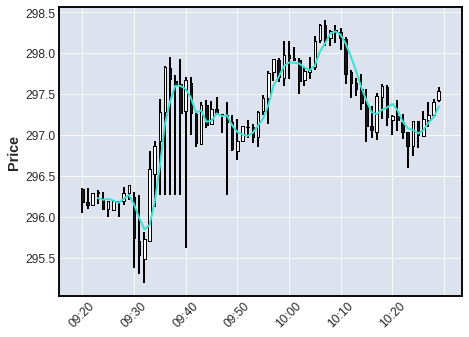

In [9]:
plt.figure(figsize = (45,15))
mpf.plot(taq.timeBars.loc['AAPL'], type = 'candle',mav = 4)

In [30]:
taq.data[taq.data.ticker == 'AAPL']

,ticker,exchange,volume,price,priceXvolume,timestamp,date,ticks
18938,AAPL,Q,19,296.3400,5630.4600,2020-01-02 09:20:00,2020-01-02,0.0
18939,AAPL,Q,1,296.3300,296.3300,2020-01-02 09:20:00,2020-01-02,-1.0
18940,AAPL,K,4,296.3300,1185.3200,2020-01-02 09:20:00,2020-01-02,-1.0
18941,AAPL,D,431,296.3202,127714.0062,2020-01-02 09:20:00,2020-01-02,-1.0
18942,AAPL,D,1,296.3400,296.3400,2020-01-02 09:20:00,2020-01-02,1.0
...,...,...,...,...,...,...,...,...
98555,AAPL,C,42,297.4600,12493.3200,2020-01-02 10:29:00,2020-01-02,-1.0
98556,AAPL,K,76,297.4900,22609.2400,2020-01-02 10:29:00,2020-01-02,1.0
98557,AAPL,K,100,297.5000,29750.0000,2020-01-02 10:29:00,2020-01-02,1.0
98558,AAPL,D,100,297.5263,29752.6300,2020-01-02 10:29:00,2020-01-02,1.0


In [0]:
aapl = taq.data[taq.data.ticker == 'AAPL']
abs_Ebv_init = abs(aapl.ticks.mean())
ticks = aapl.ticks
ET_init = 20000


In [46]:
exp_ticks = 140
avg = abs(ticks.mean())
thresh = exp_ticks * avg
print(thresh)

4.313129537062621


In [0]:
cumsum = np.abs(ticks.cumsum())

In [48]:
cumsum >= thresh

18938    False
18939    False
18940    False
18941    False
18942    False
         ...  
98555     True
98556     True
98557     True
98558     True
98559     True
Name: ticks, Length: 79622, dtype: bool

## Ticker Specific

In [0]:
QQQ = data[data.SYM_ROOT == 'QQQ']

In [0]:
QQQ.shape

(35788, 13)

In [0]:
QQQ.EX.value_counts()

Q    10001
D     6265
P     6156
Z     4299
K     3659
Y     1193
N     1133
X      879
B      698
J      653
V      601
C      164
A       70
M       17
Name: EX, dtype: int64

In [0]:
IBM = data[data.SYM_ROOT == 'IBM']

In [0]:
IBM.EX.value_counts()

D    2129
Z    1283
N    1101
T    1032
K     686
P     582
Y     395
J     327
V     116
B      38
C      18
X      11
A       2
M       1
Name: EX, dtype: int64

In [0]:
IBM[IBM.DATE == 20200103]

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
